# **Calculating the shift of simulated observations between different bands**
Our goal is to determine the time variability of the light curves of quasars. To accomplish this, we want to construct a single light curve for an object by merging observations in multiple color bands.

We can expect that there is a shift in magnitude/flux between different filters' observations, but we also anticipate a potential shift in time due to the light observed in different filters coming from different parts of the accretion disk. The simulated light curves will be shifted by some arbitrary offset (in both magnitude/flux and time) and we seek to find the amount by which to shift them back. 

The following methods will be applied:
* Subtracting the means
* Minimizing standard deviation
* Minimizing distance to nearest neighbor (of other dataset)
* Minimizing chi squared statistic
* Coregionalized Regression

In [35]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import chisquare
import GPy

import functions as fcn # my own little python file to keep things compact

## Our simulated data
Our data was generated using a damped random walk. We have 3 different cadences we want to observe at:

* Idealized Daily Observations
* Wide Fast Deep (the default LSST cadence)
* [Deep Drilling Fields](https://www.lsst.org/scientists/survey-design/ddf)

These are the cadences we will use to test our methods. Light curves were generated by [Weixiang Yu](https://github.com/ywx649999311/lsst_cadence/blob/master/DDF%20light%20curve.ipynb).

### Idealized Daily Observations
This data represents a dataset where observations for each band were taken each day for all bands simultaneously. Note that this data has no filters, so the output will be the same for each band, just shifted, when extracted.

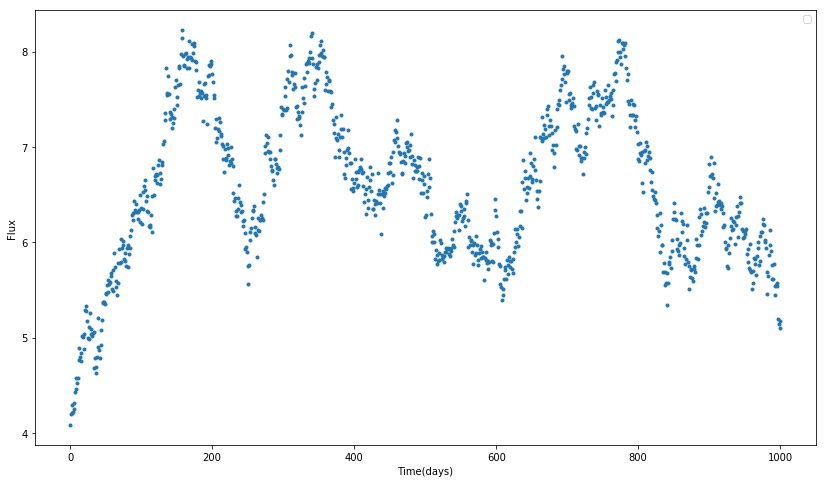

In [36]:
daily = pd.read_csv('./data/daily_drw.csv') # change the path to your directory

fig = plt.figure(figsize=(14,8))
time, flux = fcn.extract_no_filter(daily, timerange=(0,1000))
plt.plot(time, flux, '.')
plt.xlabel('Time(days)')
plt.ylabel('Flux')
plt.legend()
plt.show()

### Wide Fast Deep (WFD)
This data represents simulated light curves observed at LSST's default cadence.
(OpSim is Minon_1016.)

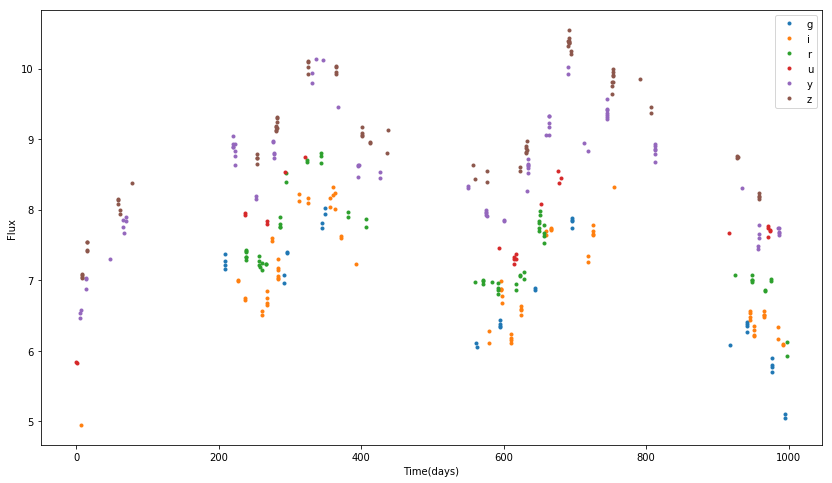

In [37]:
# Read in light curve
wfd = pd.read_csv('./data/wfd_drw.csv') # change the path to your directory

# let's look at all the bands to see the relevant cadences for each
all_filters = np.unique(wfd['filter'])

fig = plt.figure(figsize=(14,8))
for i,color in enumerate(all_filters):
    time, flux = fcn.extract_filters(color, wfd, timerange=(0,1000))
    plt.plot(time, flux+(0.5*i),'.', label=color)#seperating them to see the cadence better
plt.xlabel('Time(days)')
plt.ylabel('Flux')
plt.legend()
plt.show()

### Deep Drilling Fields (DDF)
This data represents simulated light curves observed at LSST's DDF cadence.

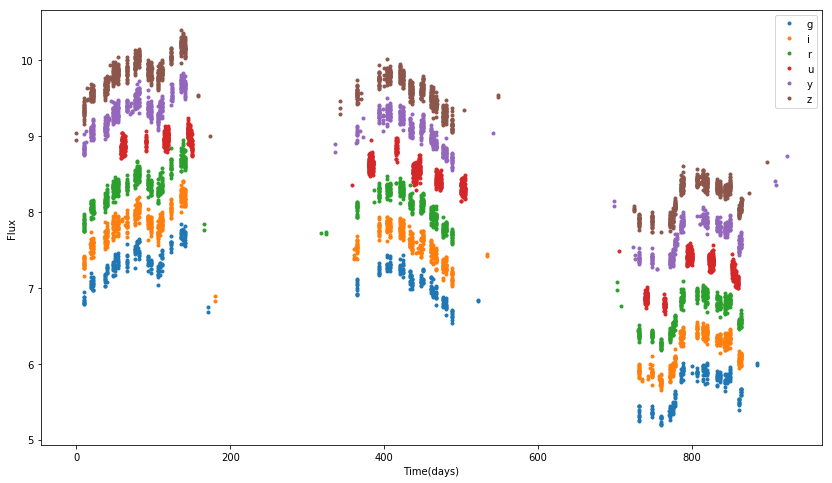

In [38]:
# Read in light curve
ddf = pd.read_csv('./data/drw_lc.csv') # change the path to your directory

# let's look at all the bands to see the relevant cadences for each
all_filters = np.unique(ddf['filter'])

fig = plt.figure(figsize=(14,8))
for i,color in enumerate(all_filters):
    time, flux = fcn.extract_filters(color, ddf, timerange=(0, 1000))
    plt.plot(time, flux+(0.5*i),'.', label=color)#seperating them to see the cadence better
plt.xlabel('Time(days)')
plt.ylabel('Flux')
plt.legend()
plt.show()

## Subtracting the mean values
We'll start by taking the simple approach of calculating the mean value of the magnitude/flux of each filter and then subtract one form the other.

<img src='./images/meandiff-edited.png'>


We would then shift the second dataset (blue) by $+8.1$ in the y direction. Note that this method will be unable to find any shift in the time domain, but it's a good starting place.

We'll define a function to return the difference of the means--this is how much we're going to shift the second light curve by.

In [39]:
def means_diff(y1, y2):
    '''
    subtracts one average from the other
    '''
    return np.mean(y1) - np.mean(y2)

## Minimizing Standard deviation
We can treat the light curve as two discrete distributions (in time and in flux/magnitude) and find the standard deviation of each distribution. Because the standard deviation represents the "spread" of the data, we will minimize it using scipy's minimize function.

It's helpful if we look at an example dataset (where $x$ would be time and $y$ would be flux/magnitude) to better understand what's going on:

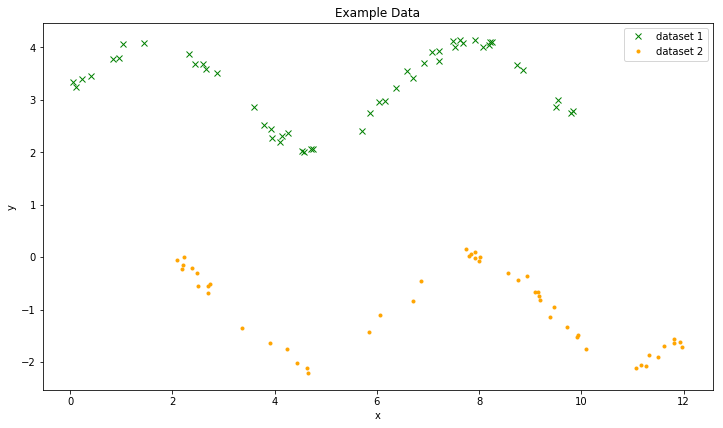

In [40]:
# generate sample data
mean1 = 3.1
mean2 = -1.0
x1 = 10*np.random.rand(50)
x2 = 10*np.random.rand(50) + 2 #added shift in x (time)
y1 = fcn.add_noise(np.sin(x1))+mean1
y2 = fcn.add_noise(np.sin(x2))+mean2

#plot
plt.figure(figsize=(12,6.75))
plt.plot(x1, y1, 'x', color='g', label='dataset 1')
plt.plot(x2, y2, '.', color='orange', label='dataset 2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Example Data')
plt.legend()
plt.savefig('./images/std-data.png')

We can create a histogram of the frequency of x and y values for the two datasets.

y std: 2.245297170850188
y median: 1.082548530484336
x std: 3.252126790046606
x median: 6.788078950117217


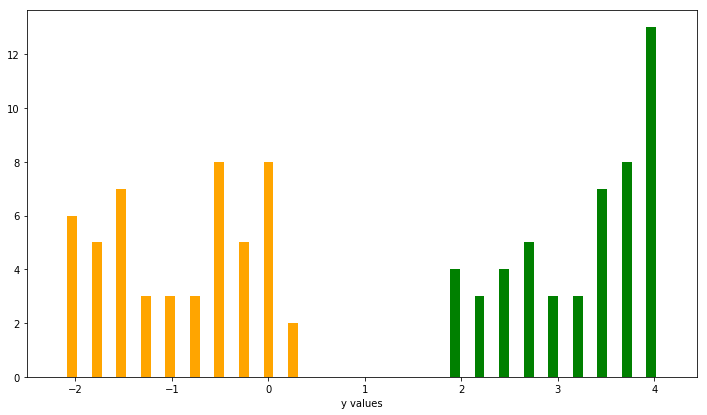

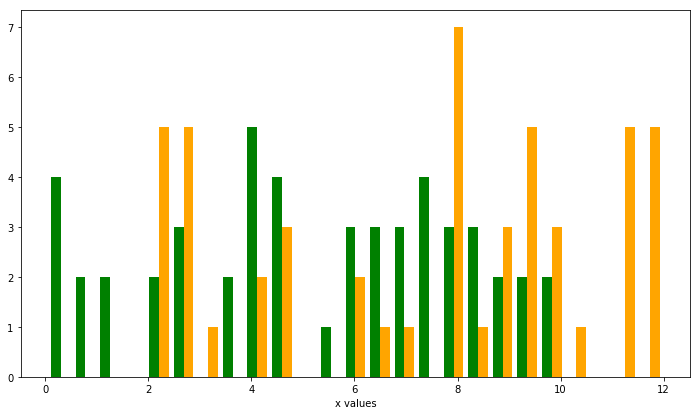

In [41]:
plt.figure(figsize=(12,6.75))
a,b,c = plt.hist([y1, y2], len(y1)/2, histtype='bar', color=['g','orange'])
plt.xlabel('y values')

print 'y std:', np.std(np.concatenate([y1, y2]))
print 'y median:', np.median(np.concatenate([y1, y2]))

plt.figure(figsize=(12,6.75))
d,e,f = plt.hist([x1, x2], len(x1)/2, histtype='bar', color=['g','orange'])
plt.xlabel('x values')

print 'x std:', np.std(np.concatenate([x1, x2]))
print 'x median:', np.median(np.concatenate([x1, x2]))

We can see that the y value distributions look like two separate distributions. We treat the entire y-value distribution as a single, bimodal distribution and calculate the standard deviation for it. Same for the x-values.

y std: 0.7173662247008302
y median: 3.4454997534463585
moved green data by 4.255229770212496 in y
x std: 3.082933400895666
x median: 5.8523698563588535
moved green data by -2.070633993068397 in x


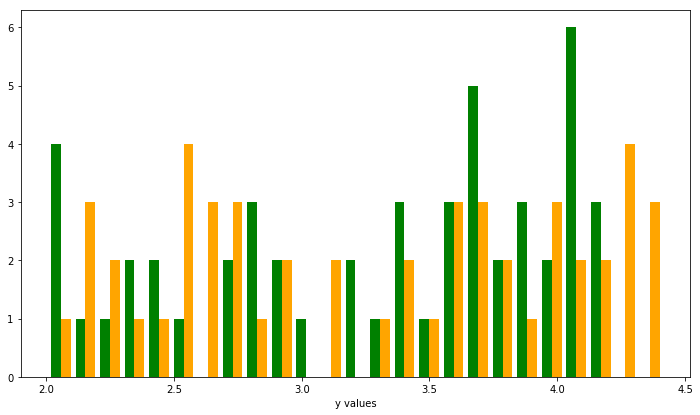

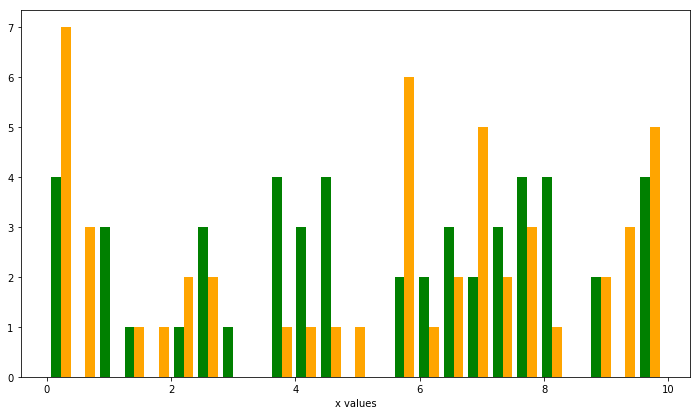

In [42]:
# we minimize the y-standard deviation of the entire distribution
opt = minimize(lambda k: np.std(np.concatenate([y1, y2+k])), 1.0)

plt.figure(figsize=(12,6.75))
a,b,c = plt.hist([y1, y2+opt.x], len(y1)/2, histtype='bar', color=['g','orange'])
plt.xlabel('y values')

print 'y std:', np.std(np.concatenate([y1, y2+opt.x]))
print 'y median:', np.median(np.concatenate([y1, y2+opt.x]))
print 'moved green data by', opt.x[0], 'in y'



# we minimize the x-standard deviation of the entire distribution
opt = minimize(lambda k: np.std(np.concatenate([x1, x2+k])), 1.0)

plt.figure(figsize=(12,6.75))
a,b,c = plt.hist([x1, x2+opt.x], len(y1)/2, histtype='bar', color=['g','orange'])
plt.xlabel('x values')

print 'x std:', np.std(np.concatenate([x1, x2+opt.x]))
print 'x median:', np.median(np.concatenate([x1, x2+opt.x]))
print 'moved green data by', opt.x[0], 'in x'

When generating this sample data, we put added in a shift of $+2$ in $x$ and $-4.1$ (difference of the means) in $y$. The green data was able to be shifted back (roughly) by the negative of those amounts. Thus the distributions become closer together--reducing the spread.

Note that this method does not take into account any covariance and instead treats the x and y variables as independent. This approach is similar to subtracting the means in its simplicity, but now returns a shift in 2 dimensions. 

We define the function to minimize our "loss" (sum of standard deviations in time and flux) and return the shift in magnitude and time that gives the optimized results.

In [43]:
def min_std(x1, y1, x2, y2):
    '''
    Function to calculate the ideal transformation between two light curves
    (by minimizing the std deviation)
    '''
    
    def std_dev(params):
        '''
        Function to calculate the "spread" of the data
        (this is the function we're going to minimize)
        '''
        dx, dy = params # args are like this so I can use the minimization function
        x = np.concatenate([x1, x2+dx])
        y = np.concatenate([y1, y2+dy])

        # We care "10x as much" about syncing them up vertically (magnitude/flux) than horizontally (time)
        return np.std(x) + np.std(y)*10.0
    
    # optimize it

    # minimize std devs (might be too simple of an approach), start with initial guess
    initial_guess = [1.0, 1.0]
    bounds = ((-25.0, 25.0), (-np.inf,np.inf)) # we don't want too much of a shift in time
    optm = minimize(std_dev, initial_guess, bounds=bounds)
    print optm

    return optm.x # get the optimal params
    

## Minimizing nearest neighbor distance
We want to find the best shift by minimizing the sum of the euclidean distances to the nearest data point in the other dataset. For each data point in the first band, we calculate the "distance" (we're treating both parameters as distances) to the nearest data point in the second band. We try to minimize the sum of these distances (squared).

\begin{equation*}
d^2 = (x - x_{nn})^2 +  (y - y_{nn})^2
\end{equation*}

So our loss function looks like:

\begin{equation*}
loss = \sum_i (x_i - x_{nn})^2 +  (y_i - y_{nn})^2
\end{equation*}

Where:
* $i$ represents a given data point in the first dataset
* $nn$ represents the nearest neighbor point in the other dataset

<img src='./images/nn-edited.png'>

Like with the standard deviation, we define a function that will minimize our "loss" and return the optimal shift values.

In [44]:
def min_nearest(x1, y1, x2, y2):
    '''
    Function to calculate the ideal transformation between two light curves
    for the follwing metric: distance to nearest neighbors
    '''
    
    def nearest(params):
        '''
        nearest neighbor calculation (returns sum of all nn distances)
        '''
        dx, dy = params # args are like this so I can use the minimization function
        #x = np.concatenate([x1, x2+dx])
        #y = np.concatenate([y1, y2+dy])
        
        dist_sum = 0.0
        for x,y in zip(x1, y1):
            # find nearest neighbor
            distances = np.square((x2+dx).flatten() - x) + np.square(y2+dy - y) 
            neighbor = np.argmin(distances)
            
            # add the (euclidian) distance squared
            dist_sum += np.sum(distances[neighbor])
        
        # return sum of the distance
        return dist_sum
    
    # minimize, start with initial guess [1, 1]
    initial_guess = [1.0, 1.0]
    bounds = ((-25.0, 25.0), (-np.inf,np.inf)) # we don't want too much of a shift in time
    optm = minimize(nearest, initial_guess, bounds=bounds)
    print optm

    return optm.x # get the optimal params

## Minimizing chi squared statistic
We want to line up the fits to the two datasets by minimizing the [chi squared statistic](http://www.stat.yale.edu/Courses/1997-98/101/chigf.htm) between the two fits. Gaussian process regression is used to fit each of the datasets separately. Then one fit is treated as the "observed" and the other is treated at the "predicted" set in the chi squared calculation.

\begin{equation*}
\chi^2 = \sum \frac{(observed - predicted)^2}{predicted}
\end{equation*}

Again, we define a function that will minimize our "loss" and return the optimal shift values. 

Note: This function takes a longer to run than the others.

In [45]:
def min_chi_squ(x1, y1, x2, y2):
    '''
    Function to calculate the ideal transformation between two light curves
    for the follwing metric: chi square test
    '''
    
    def chi_squ(params):
        '''
        chi square calculation 
        '''
        dx, dy = params # args are like this so I can use the minimization function
        x = np.concatenate([x1, x2+dx])
        y = np.concatenate([y1, y2+dy])
        XRange = np.linspace(np.min(x), np.max(x)).reshape(-1,1)
        
        # Create regression of both datasets
        Predict1, var1 = fcn.krig(g_time, g_flux, XRange)
        Predict2, var2 = fcn.krig(r_time+dx, r_flux+dy, XRange)
        
        
        # Calculate chi squared
        return chisquare(f_obs = Predict2, f_exp = Predict1)[0]
    
    # minimize, start with initial guess [1, 1]
    initial_guess = [1.0, 1.0]
    bounds = ((-25.0, 25.0), (-np.inf,np.inf)) # we don't want too much of a shift in time
    optm = minimize(chi_squ, initial_guess, bounds=bounds)
    print optm

    return optm.x # get the optimal params

## Coregionalized Regression
We want to use GPy's [coregionalized regression model](https://bigaidream.gitbooks.io/subsets_ml_cookbook/content/bayes/gp/coregionalized_regression_gpy.html) to extract the shift values between bands. Coregionalized Regression assumes a some sort of relationship between the two datasets and uses that to fit to each of the datasets. When applying it to some data, it returns two fits. One for the first dataset and one for the second (that takes the first one into account).

Text(0.5,1,u'fit 2')

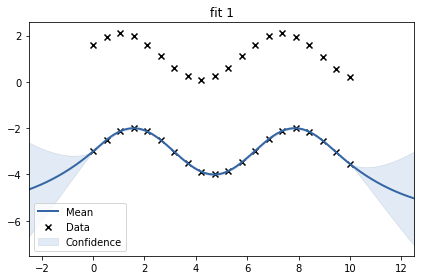

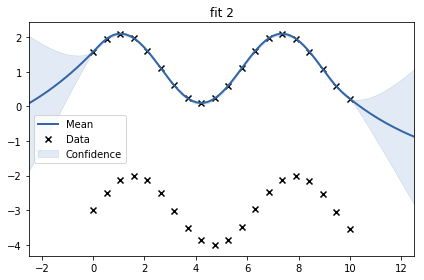

In [46]:
# create data
mean1 = -3.0
mean2 = 1.1
x1 = np.linspace(0,10, 20)
x2 = np.linspace(0,10, 20)
y1 = np.sin(x1)+mean1
y2 = np.sin(x2+0.5)+mean2


# reshape data
X1 = x1.reshape(-1,1)
X2 = x2.reshape(-1,1)
Y1 = y1.reshape(-1,1)
Y2 = y2.reshape(-1,1)

# define model for coregionalized regression
K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=K)
m = GPy.models.GPCoregionalizedRegression([X1, X2], [Y1, Y2], kernel=icm)

#Use Matern kernel and optimize
m['.*Mat32.var'].constrain_fixed(1.) 
m.optimize()


m.plot(fixed_inputs=[(1,0)])
plt.title('fit 1')

m.plot(fixed_inputs=[(1,1)])
plt.title('fit 2')

The first plot is regular regression of dataset 1 without accounting for dataset 2. The second plot is the regression of dataset 2 while accounting for the relationship between the two datasets.

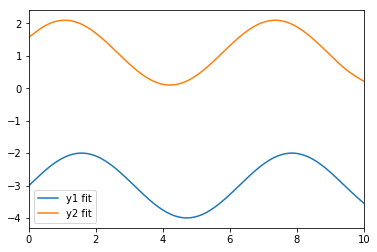

In [47]:
# plotting prediction (in a way we can use)
newX = np.linspace(np.min(m.X[:,0]), np.max(m.X[:,0]), 1000)[:,None]
newX0 = np.hstack([newX,np.zeros_like(newX)])

newX = np.linspace(np.min(m.X[:,0]), np.max(m.X[:,0]), 1000)[:,None]
newX1 = np.hstack([newX,np.ones_like(newX)])

# don't worry about the numbering too much, 0 refers to datset 1 and 1 refers to dataset 2
pred0, err0 = m.predict_noiseless(newX0)
pred1, err1 = m.predict_noiseless(newX1)#,Y_metadata=noise_dict)

plt.plot(newX[:,0], pred0, label='y1 fit')
plt.plot(newX[:,0], pred1, label='y2 fit')
plt.xlim(np.min(m.X[:,0]), np.max(m.X[:,0])) # only worrying about where we have data
plt.legend()

When applying coregionalized regression, it (visually) appears as if the fits returned are the same, just shifted by some amounts in x and y. We want to be able to just subtract them and hopefully get a value for a shift in y.

Text(0.5,1,u'difference between fits')

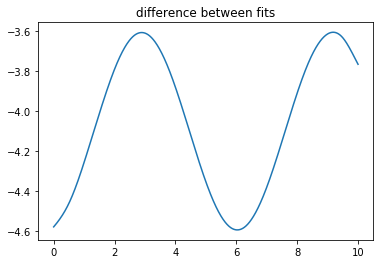

In [48]:
plt.plot(newX[:,0], pred0-pred1)
plt.title('difference between fits')

Note that this looks just like our original function, which is what we get when we subtract a phase shifted function. To extract the shifts, we're going to pick out similar points in the function and see the where they occur in x and y. We'll calculate the median of each and see where it occurs in each of the respective datasets, then the difference between the occurrence are our shifts.

In [49]:
# get median
med1 = np.median(pred0)
med2 = np.median(pred1)

#find the x,y where the medians occur (don't mind the numbering)
x1_med = newX[:,0][fcn.find_nearest_index(pred0, med1)]
x2_med = newX[:,0][fcn.find_nearest_index(pred1, med2)]
print "x shift: ", x1_med - x2_med

y1_med = pred0[fcn.find_nearest_index(pred0, med1)][0]
y2_med = pred1[fcn.find_nearest_index(pred1, med2)][0]
print "y shift: ", y1_med - y2_med

x shift:  0.5505505505505512
y shift:  -4.051536935530125


To summarize, our steps look like this:
1. Apply coregionalized regression to our two datasets to take into account the relationship between datasets when fitting
2. Subtract the x value occurrences of the median values of the fits to get the shift in x(time)
3. Subtract the y value occurrences of the median values of the fits to get the shift in y(flux/magnitude)

We'll define a function to make this process easier (and without all the plots):

In [50]:
def cor_reg(x1, y1, x2, y2):
    '''
    Calculate the coregionalized regression and subtract the fits
    '''
    
    # reshape data for GPy/sklearn
    X1 = x1.reshape(-1,1)
    X2 = x2.reshape(-1,1)
    Y1 = y1.reshape(-1,1)
    Y2 = y2.reshape(-1,1)

    # define model for coregionalized regression
    K = GPy.kern.Matern32(1)
    icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=K)
    m = GPy.models.GPCoregionalizedRegression([X1, X2], [Y1, Y2], kernel=icm)

    #Use Matern kernel and optimize
    m['.*Mat32.var'].constrain_fixed(1.) 
    m.optimize()

    #make prediction/fits
    newX = np.linspace(np.min(m.X[:,0]), np.max(m.X[:,0]), 1000)[:,None]
    newX0 = np.hstack([newX,np.zeros_like(newX)])

    newX = np.linspace(np.min(m.X[:,0]), np.max(m.X[:,0]), 1000)[:,None]
    newX1 = np.hstack([newX,np.ones_like(newX)])

    pred1, err1 = m.predict_noiseless(newX0)
    pred2, err2 = m.predict_noiseless(newX1)#,Y_metadata=noise_dict)
    
    
    # get median
    ind1 = fcn.find_nearest_index(pred1, np.median(pred1))
    ind2 = fcn.find_nearest_index(pred2, np.median(pred2))

    #find the x,y where the medians occur and subtract the values
    dx = newX[:,0][ind1] - newX[:,0][ind2]
    dy = pred1[ind1][0] - pred2[ind2][0]
    
    return dx, dy

## **Applying each method to our data**
We'll be applying these methods to merge the r and g band data of each cadence. Note for each, we will plot the [Gaussian Process Regression](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) fit to the dataset after to better determine how good the shifts we calculate are.

We added the shifts in ourselves, so we know the answers we want to get back. The correct shifts are:

* [0.0, 0.5] for Daily observations
* [-1.0, -2.4] for WFD cadence
* [5.0, -1.3] for DDF cadence

Where the first element of the array is the shift in the time domain, and the second element is the shift in the magnitude/flux domain. Note that these are the amounts by which we want to shift the r-band data *back* by.

### *Idealized Daily Observations*
Original data:

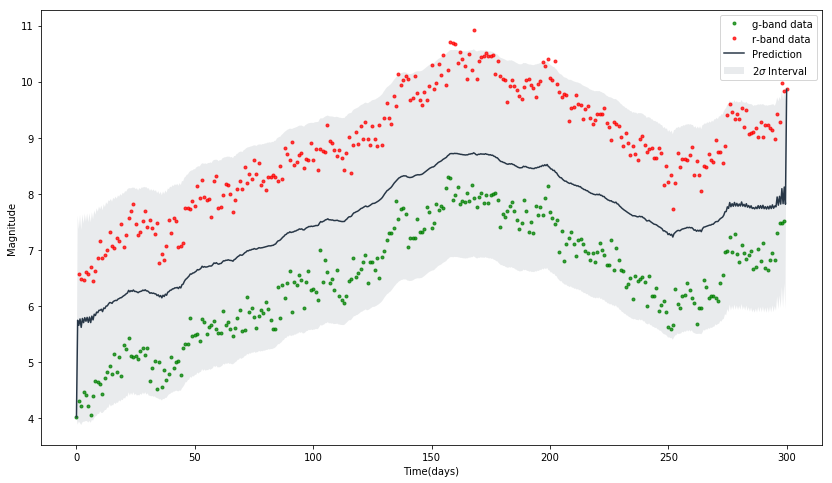

In [51]:
# Extract specific filter data
g_time, g_flux = fcn.extract_no_filter(daily, timerange=(0, 300))
r_time, r_flux = fcn.extract_no_filter(daily, xoffset=1.0, yoffset=2.4, timerange=(0, 300))
# Notice we added in our own shift to the r-band to compare to the result the optimization gives

correct = [-1.0, -2.4]

#we can add more noise to it
g_flux = fcn.add_noise(g_flux, sigma=.15)
r_flux = fcn.add_noise(r_flux, sigma=.15)

# plot
fcn.plot_krig(g_time, g_flux, r_time, r_flux, 'g', 'r')

Subtract mean values:

Found (magnitude) shift of: -2.379671010145179
Correct (magnitude) shift is: -2.4


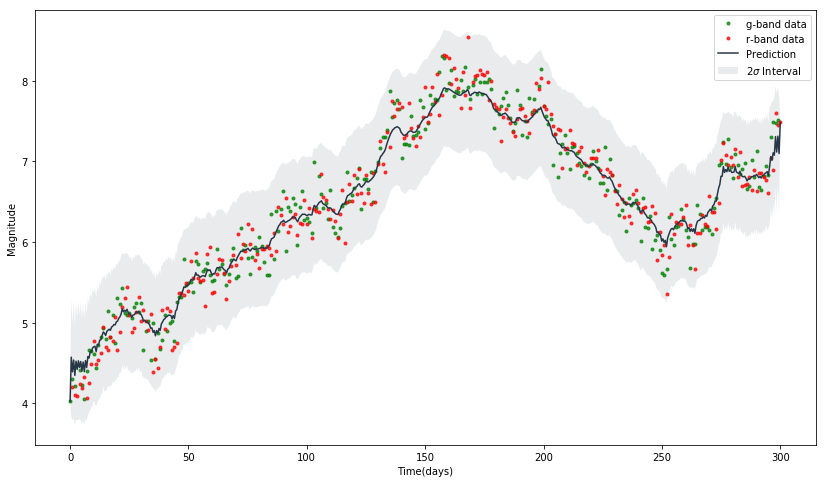

In [52]:
shift = means_diff(g_flux, r_flux)

print "Found (magnitude) shift of:", shift
print "Correct (magnitude) shift is:", correct[1]

# Krig and Plot!!!
fcn.plot_krig(g_time, g_flux, r_time, r_flux+shift, 'g', 'r')

Minimizing standard deviation:

      fun: 96.65796962035319
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 3.12638804e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 13
   status: 0
  success: True
        x: array([-1.00047583, -2.37965828])
Found shift of: [-1.0004758267488452, -2.379658278656134]
Correct shift is: [-1.0, -2.4]


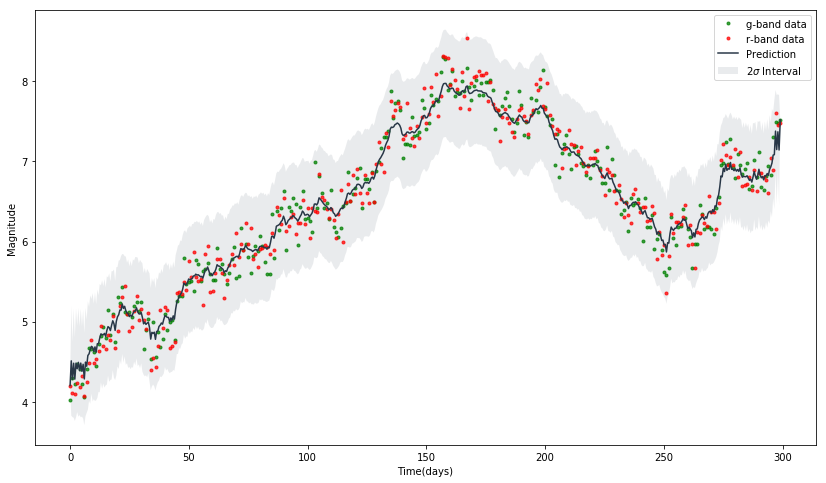

In [53]:
# Apply our optimization
dx_opt, dy_opt = min_std(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and Plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Minimizing nearest neighbor distance:

      fun: 30.171677127172643
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.61852778e-06, -7.10542736e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([ 0.9899991 , -2.35791073])
Found shift of: [0.9899990989385047, -2.3579107294499373]
Correct shift is: [-1.0, -2.4]


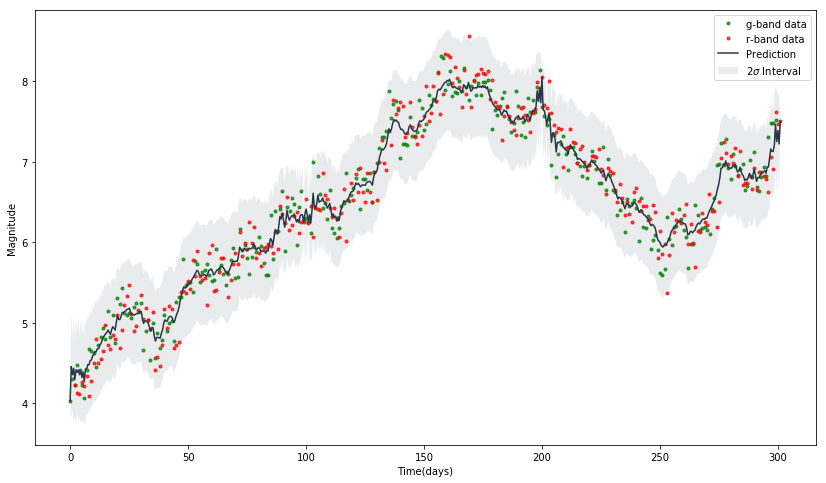

In [54]:
# optimize
dx_opt, dy_opt = min_nearest(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Minimizing chi squared statistic:

      fun: 0.48434637625139865
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.05471187e-06, -4.08562073e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([ 0.75316802, -2.37003583])
Found shift of: [0.7531680197934671, -2.3700358254105462]
Correct shift is: [-1.0, -2.4]


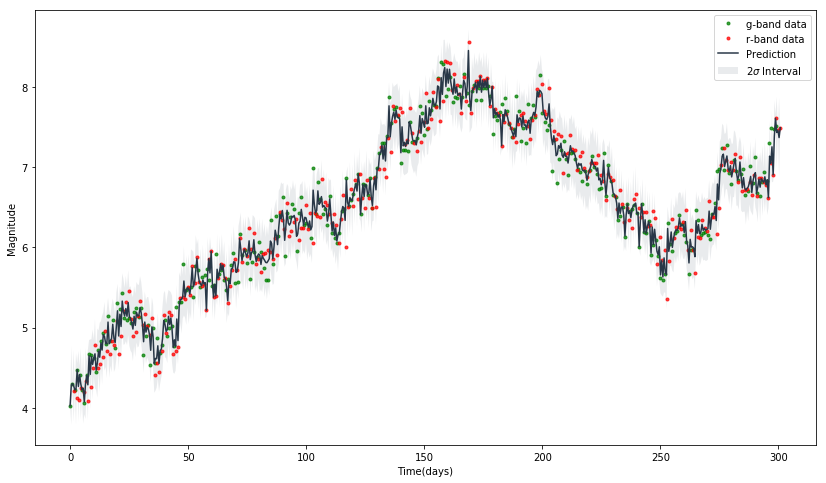

In [55]:
# optimize
dx_opt, dy_opt = min_chi_squ(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Coregionalized regression:

Found shift of: [-0.300300110438144, -2.3788641294340778]
Correct shift is: [-1.0, -2.4]


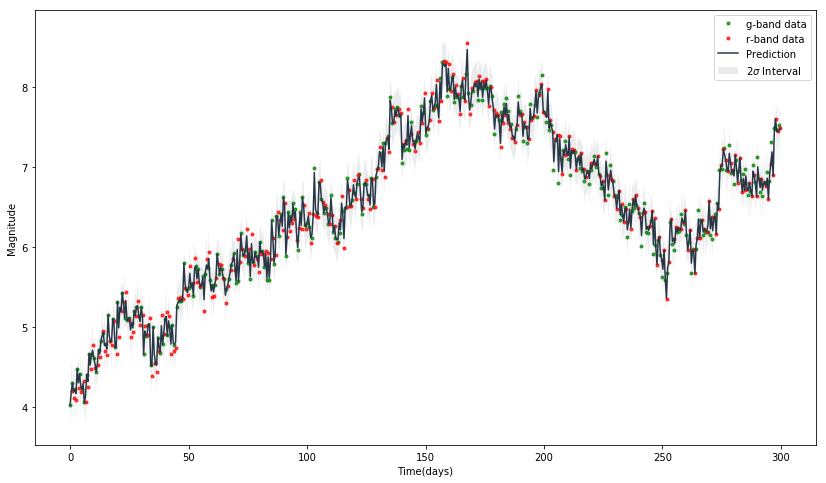

In [56]:
dx_co, dy_co = cor_reg(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_co, dy_co]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_co, r_flux+dy_co, 'g', 'r')

### *Wide Fast Deep*
Original data:

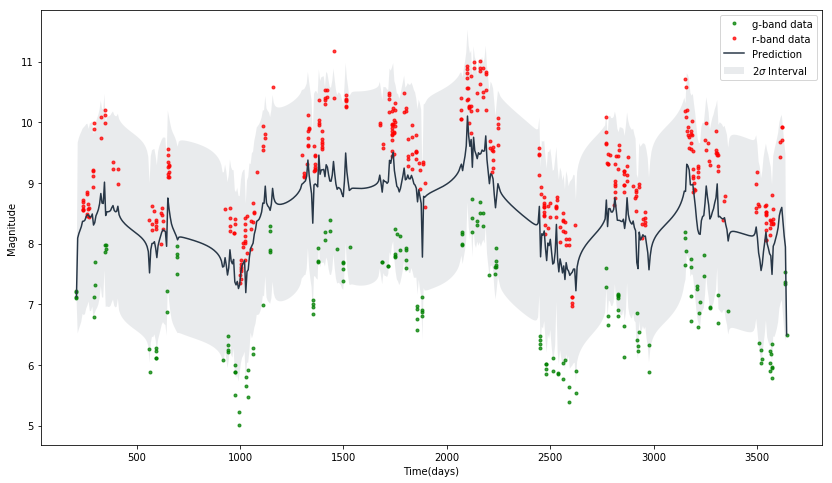

In [57]:
# Extract specific filter data
g_time, g_flux = fcn.extract_filters('g', wfd)
r_time, r_flux = fcn.extract_filters('r', wfd, xoffset=1.0, yoffset=2.4)
# Notice we added in our own shift to the r-band to compare to the result the optimization gives

correct = [-1.0, -2.4]

#we can add more noise to it
g_flux = fcn.add_noise(g_flux, sigma=.15)
r_flux = fcn.add_noise(r_flux, sigma=.15)

# plot
fcn.plot_krig(g_time, g_flux, r_time, r_flux, 'g', 'r')

Subtract mean values:

Found (magnitude) shift of: -2.215423393210579
Correct (magnitude) shift is: -2.4


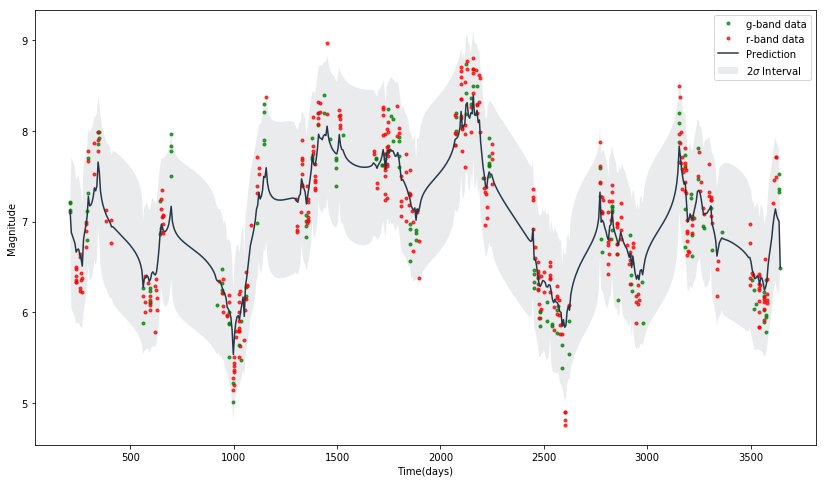

In [58]:
shift = means_diff(g_flux, r_flux)

print "Found (magnitude) shift of:", shift
print "Correct (magnitude) shift is:", correct[1]

# Krig and Plot!!!
fcn.plot_krig(g_time, g_flux, r_time, r_flux+shift, 'g', 'r')

Minimizing standard deviation:

      fun: 984.4149862625375
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 3.41060513e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 17
   status: 0
  success: True
        x: array([11.42982625, -2.2154104 ])
Found shift of: [11.429826251316113, -2.215410397199191]
Correct shift is: [-1.0, -2.4]


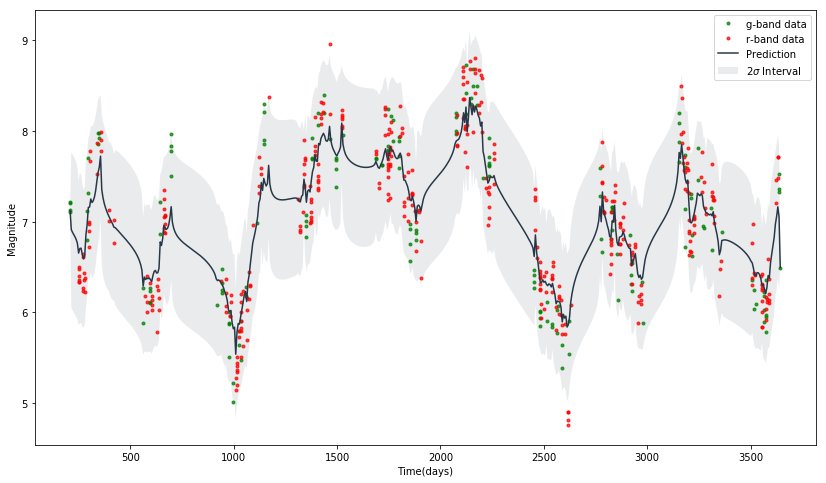

In [59]:
# Apply our optimization
dx_opt, dy_opt = min_std(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and Plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Minimizing nearest neighbor distance:

      fun: 17986.339381112284
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0167347 ,  0.00109139])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 9
   status: 0
  success: True
        x: array([-0.2888674 , -2.31699211])
Found shift of: [-0.2888673986892863, -2.3169921072371142]
Correct shift is: [-1.0, -2.4]


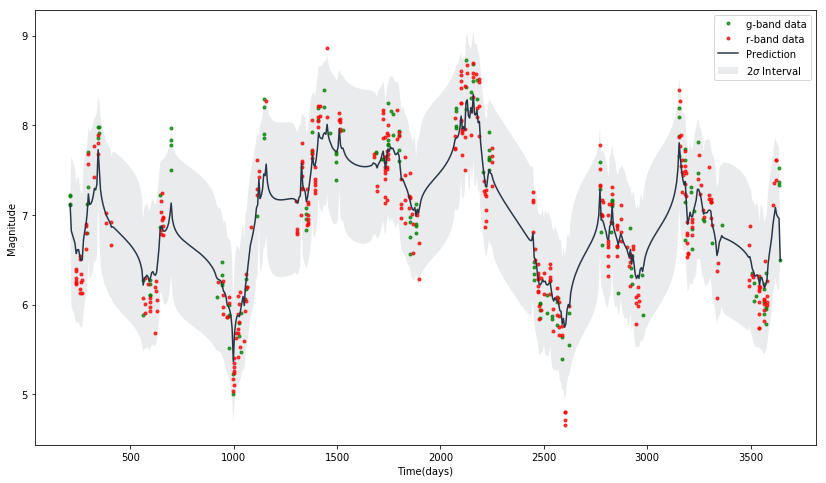

In [60]:
# optimize
dx_opt, dy_opt = min_nearest(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Minimizing chi squared statistic:

      fun: 0.2610974370317688
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.62934119e-04, -7.73325848e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 10
   status: 0
  success: True
        x: array([ 0.88376151, -2.24490101])
Found shift of: [0.8837615089529047, -2.244901005158189]
Correct shift is: [-1.0, -2.4]


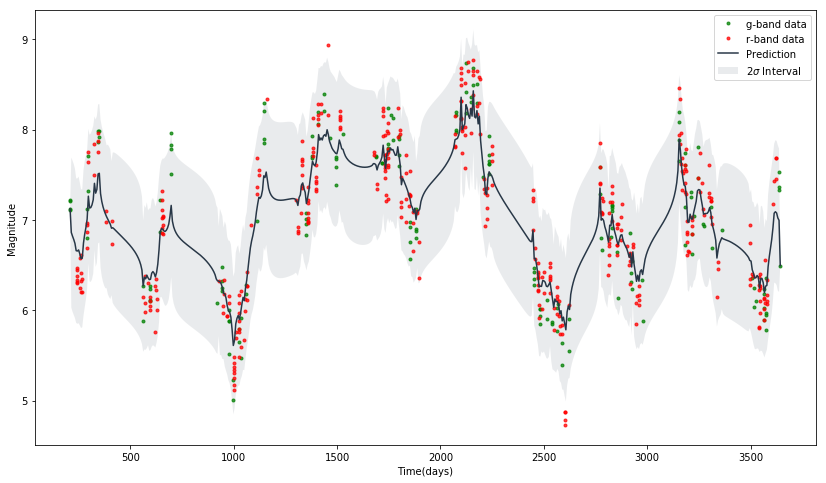

In [61]:
# optimize
dx_opt, dy_opt = min_chi_squ(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Coregionalized regression:

Found shift of: [3.4391293140988637, -2.4103210760504226]
Correct shift is: [-1.0, -2.4]


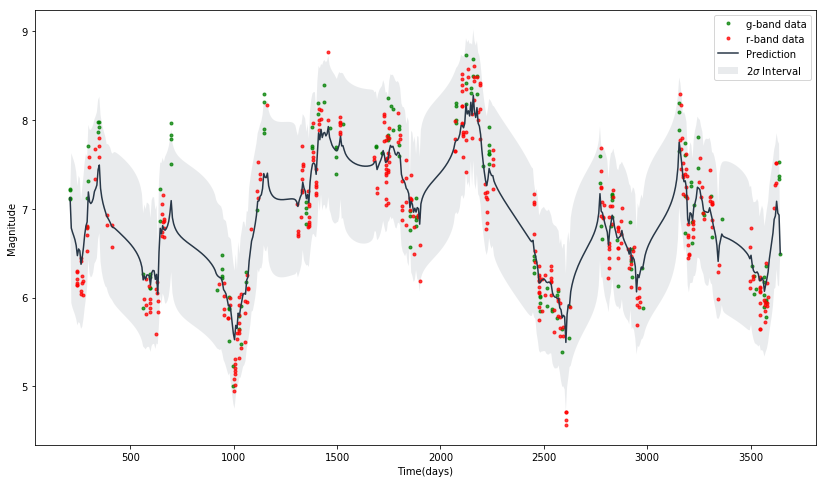

In [62]:
dx_co, dy_co = cor_reg(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_co, dy_co]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_co, r_flux+dy_co, 'g', 'r')

### *Deep Drilling Fields*
Original Data:

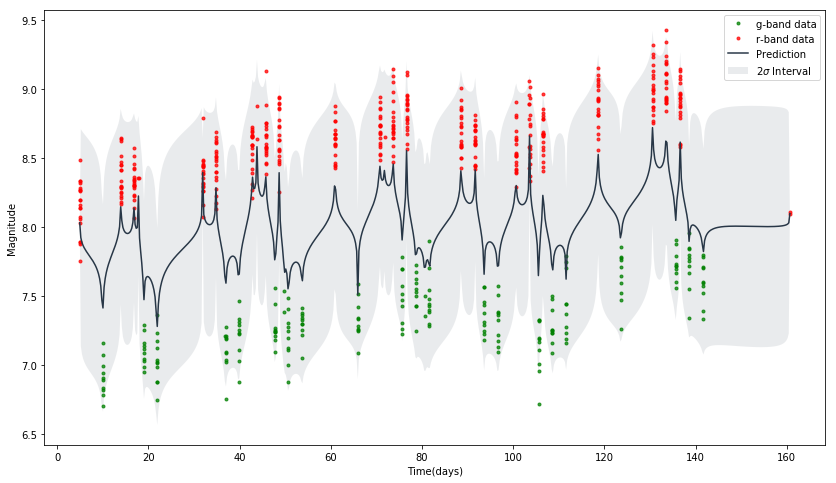

In [63]:
# Extract specific filter data
g_time, g_flux = fcn.extract_filters('g', ddf, timerange=(0,150))
r_time, r_flux = fcn.extract_filters('r', ddf, xoffset=-5.0, yoffset=1.3, timerange=(0, 200))
# Notice we added in our own shift to the r-band to compare to the result the optimization gives

correct = [-1.0, -2.4]

#we can add more noise to it
g_flux = fcn.add_noise(g_flux, sigma=.15)
r_flux = fcn.add_noise(r_flux, sigma=.15)

# plot
fcn.plot_krig(g_time, g_flux, r_time, r_flux, 'g', 'r')

Subtracting mean values:

Found (magnitude) shift of: -1.298481950014211
Correct (magnitude) shift is: -2.4


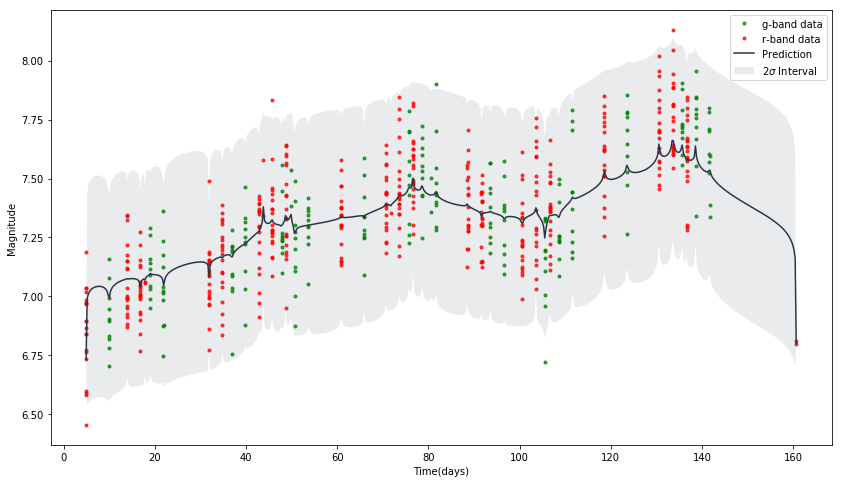

In [64]:
shift = means_diff(g_flux, r_flux)

print "Found (magnitude) shift of:", shift
print "Correct (magnitude) shift is:", correct[1]

# Krig and Plot!!!
fcn.plot_krig(g_time, g_flux, r_time, r_flux+shift, 'g', 'r')

Minimizing standard deviation:

      fun: 42.74673141693228
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.10542736e-07, 1.84741111e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 11
   status: 0
  success: True
        x: array([ 4.49675334, -1.29847965])
Found shift of: [4.496753337676525, -1.2984796528925002]
Correct shift is: [-1.0, -2.4]


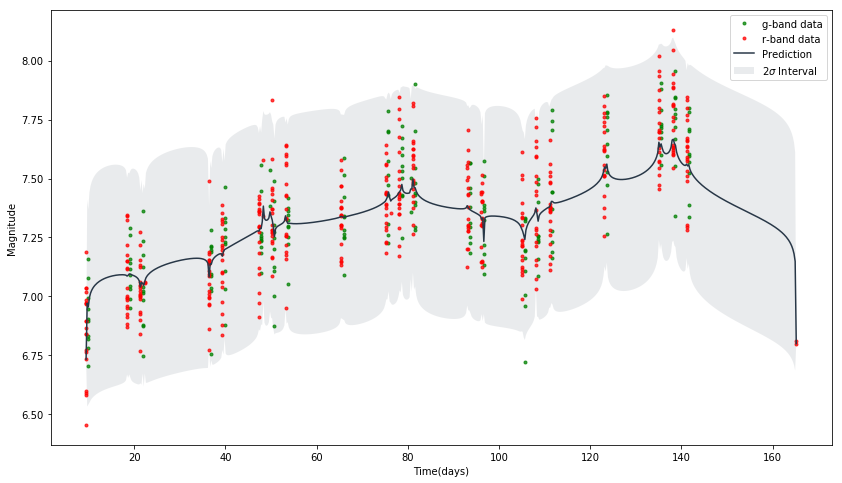

In [65]:
# Apply our optimization
dx_opt, dy_opt = min_std(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and Plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Minimizing nearest neighbor distance:

      fun: 3.969973946382319
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.21724894e-07, 3.10862447e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 14
   status: 0
  success: True
        x: array([ 4.99017079, -1.27804727])
Found shift of: [4.9901707874238665, -1.27804726977368]
Correct shift is: [-1.0, -2.4]


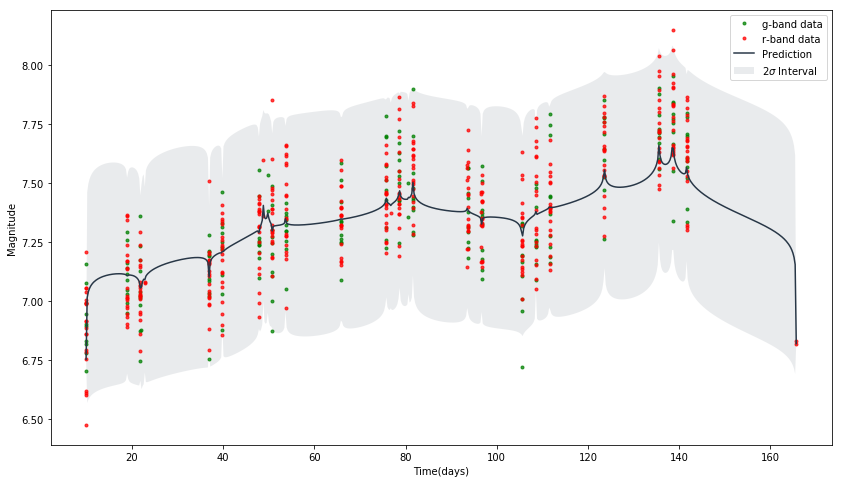

In [66]:
# optimize
dx_opt, dy_opt = min_nearest(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Minimizing chi squared statistic:

      fun: 0.08541196752269237
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.11577414e-06, 1.06858966e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 8
   status: 0
  success: True
        x: array([ 1.00947188, -1.26813344])
Found shift of: [1.0094718780993626, -1.2681334357862537]
Correct shift is: [-1.0, -2.4]


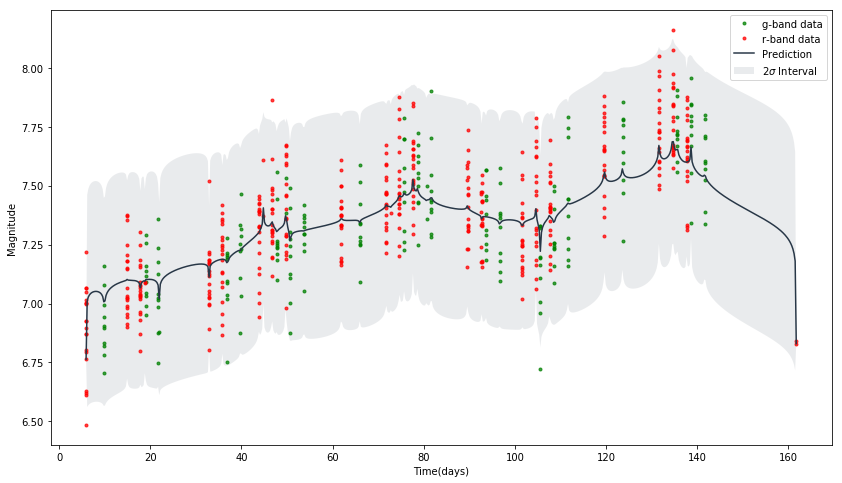

In [67]:
# optimize
dx_opt, dy_opt = min_chi_squ(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_opt, dy_opt]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_opt, r_flux+dy_opt, 'g', 'r')

Coregionalized regression:

Found shift of: [0.0, -1.3210618838503478]
Correct shift is: [-1.0, -2.4]


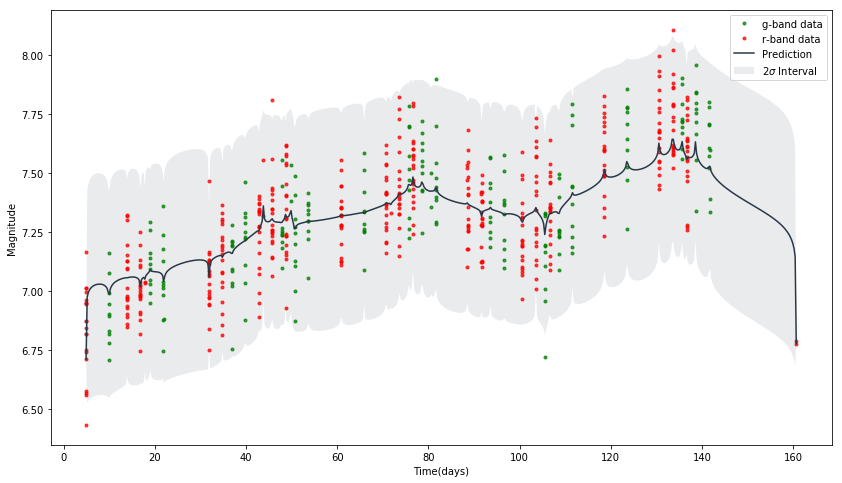

In [68]:
dx_co, dy_co = cor_reg(g_time, g_flux, r_time, r_flux)

print "Found shift of:", [dx_co, dy_co]
print "Correct shift is:", correct

# Krig and plot!!!
fcn.plot_krig(g_time, g_flux, r_time+dx_co, r_flux+dy_co, 'g', 'r')